<a href="https://colab.research.google.com/github/Meitnerium-109/citation_network_analysis/blob/main/Task_1_Exploratory_data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import random
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import defaultdict
from matplotlib.lines import Line2D
'''!wget "https://snap.stanford.edu/data/cit-HepPh.txt.gz"
!gunzip cit-HepPh.txt.gz
!wget "https://snap.stanford.edu/data/cit-HepPh-dates.txt.gz"
!gunzip cit-HepPh-dates.txt.gz'''

'!wget "https://snap.stanford.edu/data/cit-HepPh.txt.gz"\n!gunzip cit-HepPh.txt.gz\n!wget "https://snap.stanford.edu/data/cit-HepPh-dates.txt.gz"\n!gunzip cit-HepPh-dates.txt.gz'

Exploratory graph analysis, like exploratory data analysis, begins with examining the datasets provided. On examining the datasets and understanding the objective of the task, I began with data preprocessing.

A directed graph is chosen here for the representation of the citation network.

In [2]:
citations = pd.read_csv('cit-HepPh.txt', sep='\t', comment='#', names=['source', 'target']) #source node is the citing paper and target is the cited paper
dates = pd.read_csv('cit-HepPh-dates.txt', sep='\t', names=['node', 'date'], dtype={'node': int, 'date': str}, comment="#")
dates['date'] = pd.to_datetime(dates['date'], format='%Y-%m-%d')
G = nx.from_pandas_edgelist(citations, 'source', 'target', create_using=nx.DiGraph())
print(f"Node count: {G.number_of_nodes()}")
print(f"Edge count: {G.number_of_edges()}")
max_node = max(G.nodes())
all_nodes = set(G.nodes())
print(f"Maximum NodeID= {max_node}")
print(f"Minimum NodeID= {min(set(G.nodes()))}")

Node count: 34546
Edge count: 421578
Maximum NodeID= 9912553
Minimum NodeID= 1001


In [3]:
node_dates = {}
print("Raw count of papers in date dataset: ", len(set(dates['node'].unique())))
for node in dates['node']:
  temp = node
  if node > max_node: #this stringly implies cross-referenced node (beginning with prefix 11)
    node = int(str(node)[2:])
    if node not in all_nodes and str(node)[:2] == "11":
      node = int(str(node)[2:])
      if node not in all_nodes:
        continue
  if node not in all_nodes:
    continue
  if node in node_dates:
    node_dates[node] = min(node_dates[node], dates[dates['node'] == temp]['date'].iloc[0])
  else:
    node_dates[node] = dates[dates['node'] == temp]['date'].iloc[0]
print("After cleaning: ", len(node_dates))
print("Undated papers: ", len(all_nodes) - len(node_dates))
print(f"Range of papers in net: {min(node_dates.values())} to {max(node_dates.values())}")

Raw count of papers in date dataset:  37621
After cleaning:  30561
Undated papers:  3985
Range of papers in net: 1992-02-11 00:00:00 to 2002-03-12 00:00:00


There are 3985 nodes with missing date
 information.
My approach to handling missing data:

Initially I had an approach that used median of neoighbour nodes to estimate the dates of undated nodes. However, in this approach it was found that there were around ten (or in the order of 10) nodes whose neighbours were all undated. My intial approach was to neglect these nodes completely and remove them from the dataset. However after performing all the graph analyses on the reduced dataset, I decided that the graoh on removing nodes would not be representative of the citation network. Besides, for accuracy I have a backup dataset with only nodes that were dated originally. Hence in the new approach, I decided to estimate median date of all known node for the nodes whose neighbours are all undated. This might lead to clustering of nodes around the networks median. Since there are only a few of these nodes, I decided to keep them, and store them separately as well for further review.

Overall, a median based approach is quite simplistic but fairly effective (except for those with undated neighbours only).

In [4]:
def estimate_missing_dates(G, node_dates):
    estimated_dates = node_dates.copy()
    missing_nodes = [node for node in G.nodes if node not in node_dates]
    nodes_only_with_undated_neighbors = set()

    for node in tqdm(missing_nodes, desc='Estimating missing dates'):
        neighbor_dates = []
        predecessors = list(G.predecessors(node))
        successors = list(G.successors(node))
        neighbors = predecessors + successors

        for neighbor in neighbors:
            if neighbor in estimated_dates:
                neighbor_dates.append(estimated_dates[neighbor])

        if neighbor_dates:

            estimated_dates[node] = pd.to_datetime(np.median([date.value for date in neighbor_dates]))
        else:

            all_dates = [date for date in estimated_dates.values()]
            nodes_only_with_undated_neighbors.add(node)
            estimated_dates[node] = pd.to_datetime(np.median([date.value for date in all_dates]))

    return estimated_dates, nodes_only_with_undated_neighbors

Creating sample test dataset to test estimation method and running the estimate 5 times.

In [5]:
max_list = []
min_list = []
av_list = []
spl_nodes = []
for i in range(5):
  missing_nodes = all_nodes - node_dates.keys()
  t_all_nodes = all_nodes.copy() - missing_nodes
  sample_size = 3800
  sample_nodes = random.sample(list(node_dates.keys()), sample_size)
  t_node_dates = {key: value for key, value in node_dates.items() if key not in sample_nodes}

  t_missing_nodes = t_all_nodes - t_node_dates.keys()

  g = nx.subgraph(G, t_all_nodes)
  t_node_dates, spl_nodes = estimate_missing_dates(g, t_node_dates)
  diff_data = [np.abs((t_node_dates[node] - node_dates[node]).days)
      for node in sample_nodes]

  min_diff = min(diff_data)
  max_diff = max(diff_data)
  max_list.append(max_diff)
  min_list.append(min_diff)
  average_diff = sum(diff_data)/len(diff_data)
  av_list.append(average_diff)
  print()
print(f"Min: {min(min_list)}")
print(f"Max: {max(max_list)}")
print(f"Average: {sum(av_list)/len(av_list)}")


Estimating missing dates: 100%|██████████| 3800/3800 [00:01<00:00, 3111.37it/s]


Estimating missing dates: 100%|██████████| 3800/3800 [00:01<00:00, 3366.38it/s]


Estimating missing dates: 100%|██████████| 3800/3800 [00:01<00:00, 2202.82it/s]


Estimating missing dates: 100%|██████████| 3800/3800 [00:01<00:00, 3330.98it/s]


Estimating missing dates: 100%|██████████| 3800/3800 [00:01<00:00, 3365.62it/s]



Min: 0
Max: 3510
Average: 598.520947368421


The estimation method has extreme outliers in terms of accuracy, being able to estimate to almost exact equality, and having estimates with an offset of around a decade. This is a wild-card method to deal with missing data; however I am interested in the implications of this on a citation network. So, I will create a reference dataset that uses the approach of completely removing all undated nodes and compare the findings between the two.

In [6]:
nodes_with_dates = set(node_dates.keys())
G_backup = nx.subgraph(G, nodes_with_dates).copy()
node_dates_backup = node_dates.copy()
node_dates, spl_nodes = estimate_missing_dates(G, node_dates)
print("After estimate:")
print(f"Nodes: {G.number_of_nodes()}")
print(f"Nodes in backup reference set: {G_backup.number_of_nodes()}")
print(f"Nodes with only undated neighbours: \n: {spl_nodes}")


Estimating missing dates: 100%|██████████| 3985/3985 [00:00<00:00, 3993.15it/s]

After estimate:
Nodes: 34546
Nodes in backup reference set: 30561
Nodes with only undated neighbours: 
: {208197, 301132, 301100, 211183, 205169, 208052, 210325, 302197, 302100, 209304, 207130, 301083, 302172}


Node_dates now contains dates for the entire dataset, whereas node_dates_backup contains only the originally dated nodes.

With the datasets prepared, I am going to observe trends, patterns and changes over the years. First, the number of papers published each year

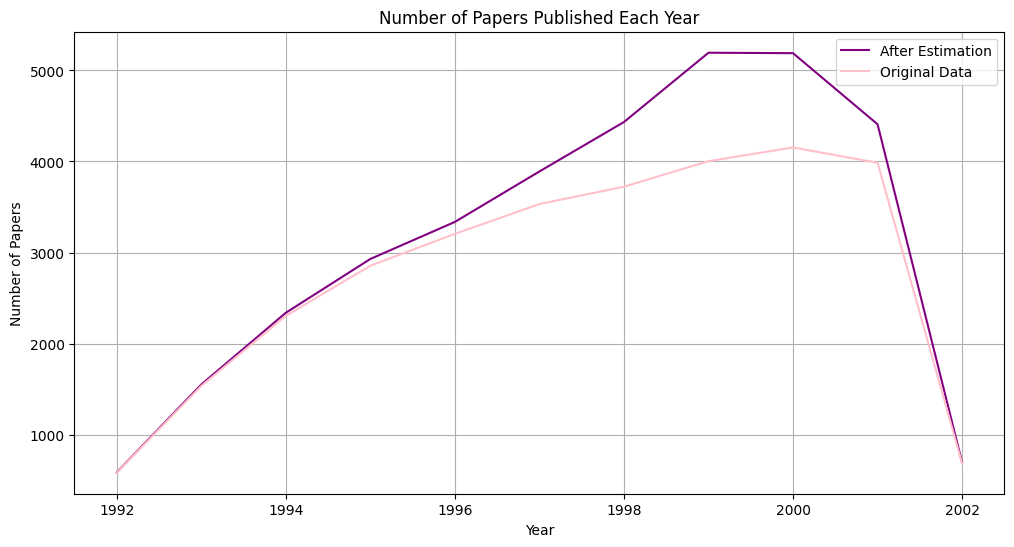

In [7]:
def plot_papers_per_year(node_dates, node_dates_backup):
    papers_per_year = pd.Series(node_dates).dt.year.value_counts().sort_index()
    papers_per_year_backup = pd.Series(node_dates_backup).dt.year.value_counts().sort_index()

    plt.figure(figsize=(12, 6))
    plt.plot(papers_per_year.index, papers_per_year.values, label='After Estimation', color='purple')
    plt.plot(papers_per_year_backup.index, papers_per_year_backup.values, label='Original Data', color='pink')
    plt.xlabel('Year')
    plt.ylabel('Number of Papers')
    plt.title('Number of Papers Published Each Year')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_papers_per_year(node_dates, node_dates_backup)

As expected, overall the estimated graph traverses higher values as it contains more nodes than the reference. Alot of the peak difference is around the 2000-2002 area, which indicates alot of undated nodes were attributed to that time period.
The undated nodes could have something in common that groups them- perhaps they belong to a subset of HEP that was highly concentrated on during the 2000-2002 period.

To test this, I want to visualise what portion of the undated nodes were estimated to the time range 2000-2002

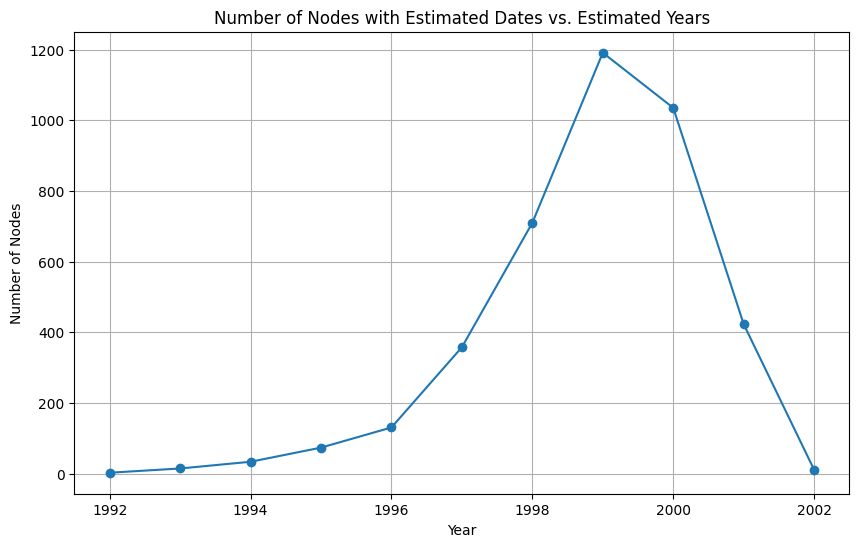

In [8]:


nodes_with_estimated_dates = [node for node in node_dates if node not in node_dates_backup]
estimated_years = [node_dates[node].year for node in nodes_with_estimated_dates]

estimated_node_counts_by_year = pd.Series(estimated_years).value_counts().sort_index()

plt.figure(figsize=(10, 6))
plt.plot(estimated_node_counts_by_year.index, estimated_node_counts_by_year.values, marker='o', linestyle='-')
plt.xlabel('Year')
plt.ylabel('Number of Nodes')
plt.title('Number of Nodes with Estimated Dates vs. Estimated Years')
plt.grid(True)
plt.show()

This confirms the hypothesis as the peak of the graph coincides with the largest difference in the other graph between the estimated and original line plots.

The dip around 2002 is attributed to the range of papers in the network. During data pre-processing this was found to be: 1992-02-11  to 2002-03-12. The graph does not account for papers published in the remaining months of 2002 and forth, hence misrepresents the number to be quite low.

Next analysis would be average in-degree of each paper in each year: how much does each year's research form as reference for future works?

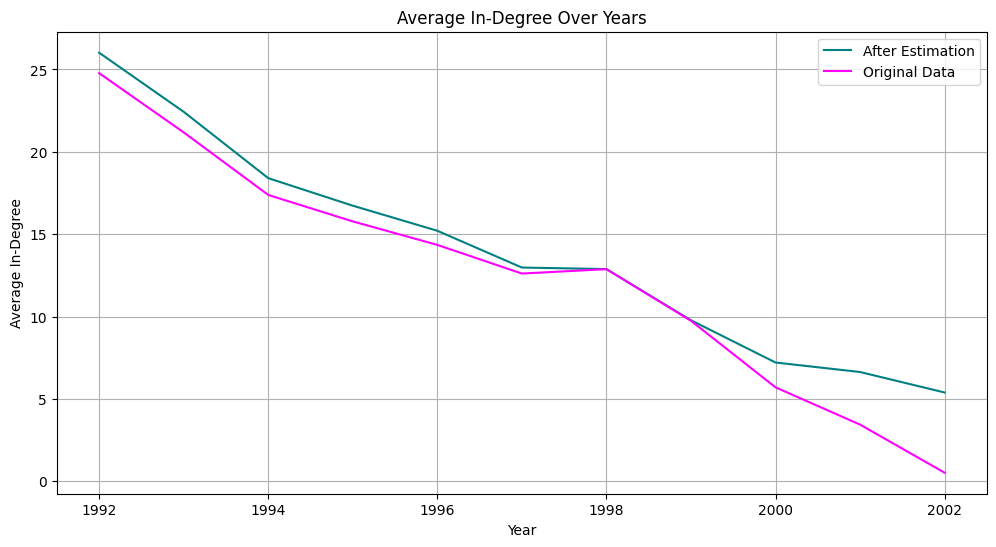

In [9]:
def plot_average_in_degree(G, node_dates, G_backup, node_dates_backup):
    def average_in_degree(G, node_dates):
        in_degrees = dict(G.in_degree())
        df = pd.DataFrame({'in_degree': in_degrees, 'date': pd.Series(node_dates)})
        avg_in_degree = df.groupby(df['date'].dt.year)['in_degree'].mean()
        return avg_in_degree

    avg_in_degree = average_in_degree(G, node_dates)
    avg_in_degree_backup = average_in_degree(G_backup, node_dates_backup)

    plt.figure(figsize=(12, 6))
    plt.plot(avg_in_degree.index, avg_in_degree.values, label='After Estimation', color='teal')
    plt.plot(avg_in_degree_backup.index, avg_in_degree_backup.values, label='Original Data', color='magenta')
    plt.xlabel('Year')
    plt.ylabel('Average In-Degree')
    plt.title('Average In-Degree Over Years')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_average_in_degree(G, node_dates, G_backup, node_dates_backup)

The reason for the variation between the two is again, as detailed for the last plot. The graph again mostly varies towards the end, from the period 2000 to 2002. The graph cannot be analysed directly as earlier papers have bias because they have been available for longer compared to later, more recent papers. It may not be indicative of the importance or relevance of the papers themselves. That is why there is an overall almost linear decrease in in-degrees with respect to time.

To examine this hypothesis, I will compute the normalised average in-degree over time. The normalisation method is dividing by the years since publication from the latest year in the dataset range, i.e., 2002. The normalisation still might not give an entirely accurate representation of the accumulation of citations. The data is analysed with this limitation in mind.

Computing normalized average in-degree: 100%|██████████| 2/2 [00:00<00:00,  8.03it/s]


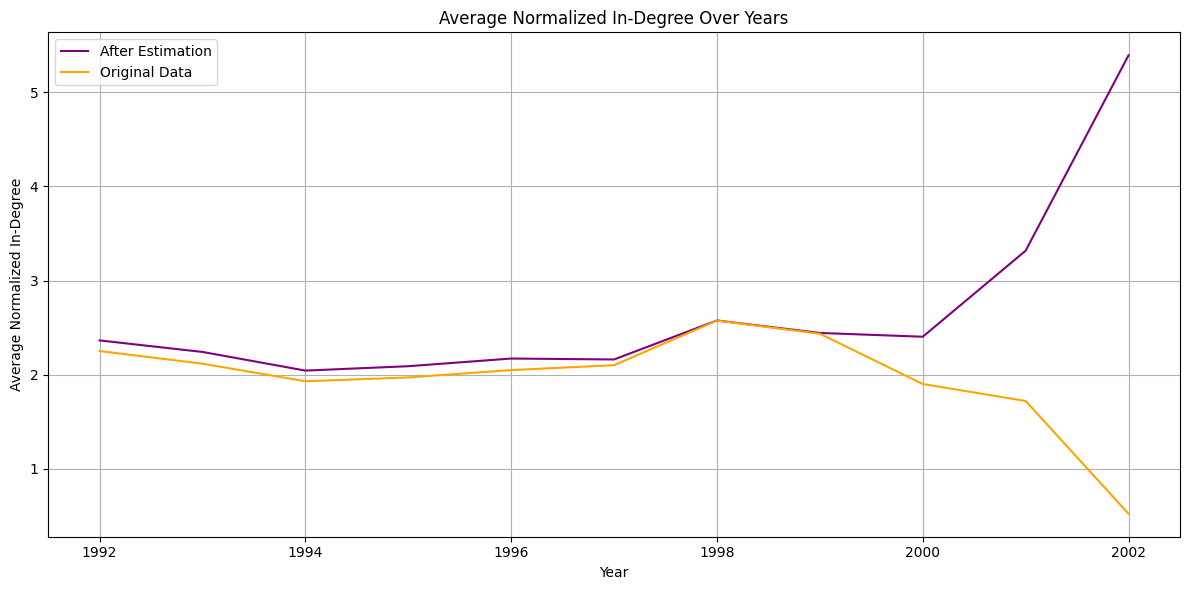

In [10]:
def plot_normalized_average_in_degree(G, node_dates, G_backup, node_dates_backup):
  max_year = max(date.year for date in node_dates.values())
  def compute_normalized_avg_in_degree(graph, dates):
    in_degrees = dict(graph.in_degree())
    df = pd.DataFrame({
            'node': list(graph.nodes()),
            'in_degree': list(in_degrees.values())
        })
    df['publication_year'] = df['node'].map(lambda x: dates[x].year)
    df['years_since_pub'] = max_year - df['publication_year'] + 1
    df['years_since_pub'] = df['years_since_pub'].replace(0, 1)
    df['normalized_in_degree'] = df['in_degree'] / df['years_since_pub']
    normalized_avg = df.groupby('publication_year')['normalized_in_degree'].mean()
    return normalized_avg
  with tqdm(total=2, desc='Computing normalized average in-degree') as pbar:
    normalized_avg = compute_normalized_avg_in_degree(G, node_dates)
    pbar.update(1)
    normalized_avg_backup = compute_normalized_avg_in_degree(G_backup, node_dates_backup)
    pbar.update(1)
  plt.figure(figsize=(12, 6))
  plt.plot(normalized_avg.index, normalized_avg.values, label='After Estimation', color='purple')
  plt.plot(normalized_avg_backup.index, normalized_avg_backup.values, label='Original Data', color='orange')
  plt.xlabel('Year')
  plt.ylabel('Average Normalized In-Degree')
  plt.title('Average Normalized In-Degree Over Years')
  plt.legend()
  plt.grid(True)
  plt.tight_layout()
  plt.show()


plot_normalized_average_in_degree(G, node_dates, G_backup, node_dates_backup)

As expected, the decrease in citations was due to age bias, and not due to relevance of the older papers themselves. However after normalization, the extreme difference between the two plots is highlighted for the period 2000 to 2002: this could indicate that a lot of missing dates were estimated to be around this period. Perhaps these nodes belong to the year 2002, after the month of march (last recorded month in dataset).

However, even if the estimation method favored larger number of papers for the 2000-2002 period, the plot for papers published per years decreases quite similarly to the reference data indicating that the increase in average in-citations is not due to the increase in papers- perhaps it documents a shift to a new direction of study that increases citations for papers within that area. Or, perhaps these papers represent a pivotal discovery that catalysed similar papers, creating higher citations.

It could also be an issue with normalisation method.

I want to analyse this interesting observation further before moving on to other properties. To do this, first I want to obtain highest values of in-degrees over the years 2000 t0 2002

In [11]:
def find_highest_indegree_nodes(graph, node_dates, years):
   highest_indegree_nodes = {}
   for year in years:

      nodes_in_year = [node for node, date in node_dates.items() if date.year == year]
      if not nodes_in_year:
          highest_indegree_nodes[year] = (None, None)
          continue
      in_degrees = graph.in_degree(nodes_in_year)
      node, degree = max(in_degrees, key=lambda x: x[1])
      highest_indegree_nodes[year] = (node, degree)
   return highest_indegree_nodes

years_of_interest = [2000, 2001, 2002]
highest_indegree_estimated = find_highest_indegree_nodes(G, node_dates, years_of_interest)
highest_indegree_original = find_highest_indegree_nodes(G_backup, node_dates_backup, years_of_interest)

def display_highest_indegree(high_est, high_orig, years):
  print("Highest In-Degree Nodes (2000-2002):\n")
  print(f"{'Year':<6}{'Estimated Node':<20}{'Est. In-Degree':<15}{'Original Node':<20}{'Orig. In-Degree':<15}")
  print("-" * 76)
  for year in years:
    est_node, est_degree = high_est.get(year, (None, None))
    orig_node, orig_degree = high_orig.get(year, (None, None))
    est_node_str = str(est_node) if est_node is not None else "N/A"
    orig_node_str = str(orig_node) if orig_node is not None else "N/A"
    est_degree_str = str(est_degree) if est_degree is not None else "N/A"
    orig_degree_str = str(orig_degree) if orig_degree is not None else "N/A"
    print(f"{year:<6}{est_node_str:<20}{est_degree_str:<15}{orig_node_str:<20}{orig_degree_str:<15}")


display_highest_indegree(highest_indegree_estimated, highest_indegree_original, years_of_interest)

Highest In-Degree Nodes (2000-2002):

Year  Estimated Node      Est. In-Degree Original Node       Orig. In-Degree
----------------------------------------------------------------------------
2000  6124                216            6124                134            
2001  106258              184            102122              136            
2002  201231              98             201231              19             


Interestingly, the highest in-degree node remains the same for both datasets.(excluding 2001), but with a shocking increase in in-degree in each case, indicating that alot of missing-date nodes cited these particular papers. One final check before moving on to the rest of the features:
I want to understand qualitatively the field of these papers and why they correlate to these estimation anomalies. Perhaps I can come to a conclusion about the nature or reason for the missing date nodes.

Paper 6124, that had close to a double number of citations in the estimate compared to the reference dataset is titled:

QCD factorization for exclusive, non-leptonic B meson decays: General arguments and the case of heavy-light final states

Paper 201231, which had around a five times increase when estimation was applied, is titled:

Evidence for Neutrinoless Double Beta Decay

I would like to investigate the second data finding a little further.

For this I want to collect all the papers that are undated, that were estimated to 2002


In [12]:

citations_to_target = citations[citations['target'] == 201231]

citing_nodes = citations_to_target['source'].unique()


undated_citing_nodes_2002 = [
    node for node in citing_nodes
    if node not in node_dates_backup and node_dates[node].year == 2002
]


print("Undated nodes citing 0201231 and estimated to be published in 2002:")
print(undated_citing_nodes_2002)
print(len(undated_citing_nodes_2002))

Undated nodes citing 0201231 and estimated to be published in 2002:
[204254, 205228, 203261, 204144]
4


Hypothesis: Date revision discrepancy:

On reference to the ArXiv HEP-PH database, it was found that all of these papers were almost **direct** conclusions and developments on the Neutrinoless Double Beta Decay topic- and all of these had publication dates a little after the last date recorded in the dataset, ie. March 2002. Alot of these papers have multiple revised publication dates.

This is also corroborated by the fact that the estimation method I designed attributed alot of the missing papers to the later period (close to the 2000s).

Perhaps each group of missing date nodes are related to one particular foundational paper that is dated and properly connected to the network. Since the dataset mentions explicitly that it excludes papers outside the time range, maybe these papers were first published within the range, but underwent multiple revised and the revsion dates exceeded the upper bound date of the dataset.


Building on this, the "special nodes" set could indicate another such experiment or niche that developed during the 2000 to 2002 timeframe whose all papers underwent the date-revision discrepancy.

Density of graph over time:

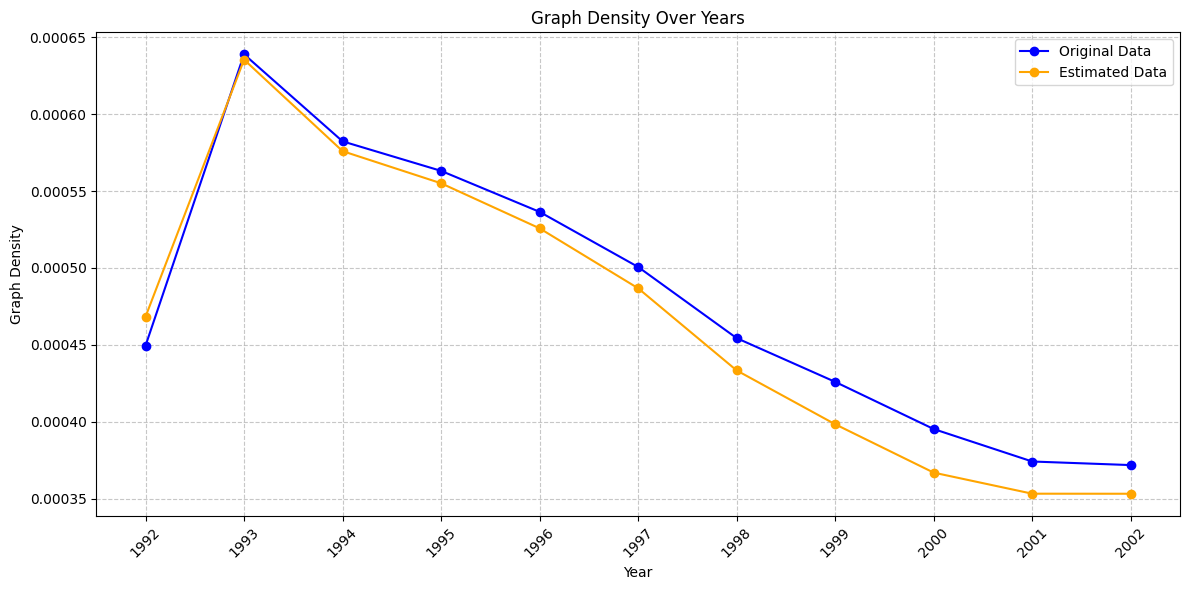

In [13]:
def plot_graph_density(G, G_backup, node_dates, node_dates_backup):
    years = sorted(set(pd.Series(node_dates).dt.year.unique()).union(set(pd.Series(node_dates_backup).dt.year.unique())))
    density_estimated = []
    density_original = []

    for year in years:
        # Estimated Dataset
        nodes_est = [node for node, date in node_dates.items() if date.year <= year]
        subG_est = G.subgraph(nodes_est)
        dens_est = nx.density(subG_est)
        density_estimated.append(dens_est)

        # Original Dataset
        nodes_orig = [node for node, date in node_dates_backup.items() if date.year <= year]
        subG_orig = G_backup.subgraph(nodes_orig)
        dens_orig = nx.density(subG_orig)
        density_original.append(dens_orig)

    plt.figure(figsize=(12, 6))
    plt.plot(years, density_original, marker='o', label='Original Data', color='blue')
    plt.plot(years, density_estimated, marker='o', label='Estimated Data', color='orange')
    plt.xlabel('Year')
    plt.ylabel('Graph Density')
    plt.title('Graph Density Over Years')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(years, rotation=45)
    plt.tight_layout()
    plt.show()

plot_graph_density(G, G_backup, node_dates, node_dates_backup)

Both datasets exhibit a lowering density indicating that the graph is a highly sparse network- this is characteristic of citation networks as each paper references only relevant papers. Like other trends, the estimated dataset shows increase in density towards the 2000-2002 period, likely attributed to the estimation method and the date-revision discrepancy hypothesis. Since the estimation process adds node dates based on neighbours (except special nodes), estimation would also increase the edges and connections hence graph density.

Average clustering coefficient over time

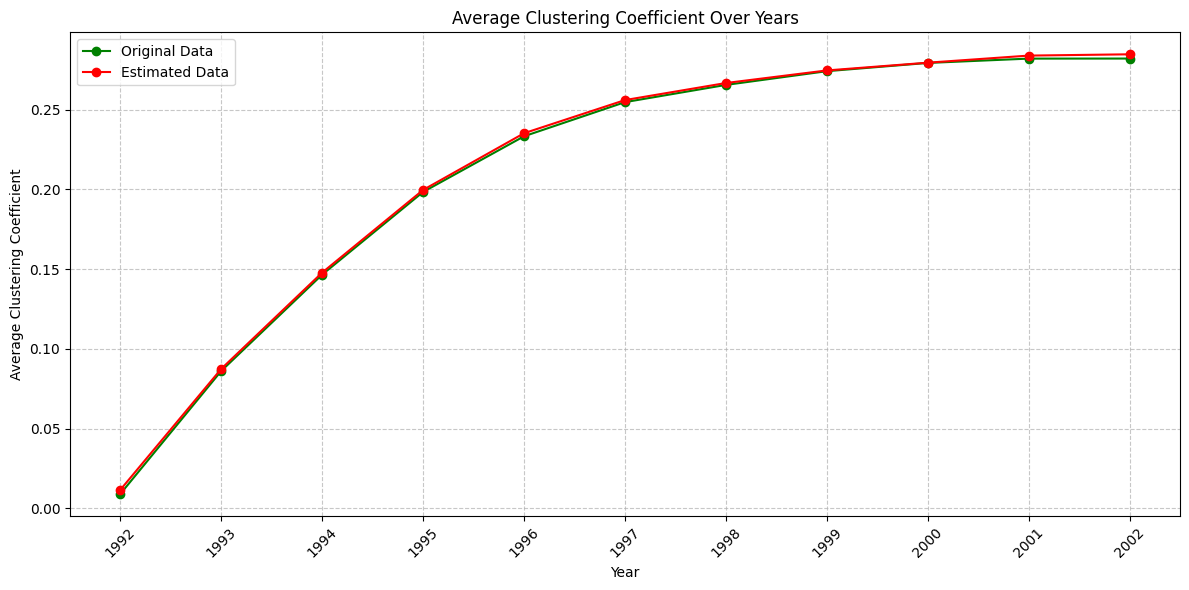

In [14]:
def plot_clustering_coefficient(G, G_backup, node_dates, node_dates_backup):
    years = sorted(set(pd.Series(node_dates).dt.year.unique()).union(set(pd.Series(node_dates_backup).dt.year.unique())))
    clust_estimated = []
    clust_original = []

    for year in years:

        nodes_est = [node for node, date in node_dates.items() if date.year <= year]
        subG_est = G.subgraph(nodes_est).to_undirected()
        if subG_est.number_of_nodes() > 2:
            clus_est = nx.average_clustering(subG_est)
        else:
            clus_est = 0
        clust_estimated.append(clus_est)


        nodes_orig = [node for node, date in node_dates_backup.items() if date.year <= year]
        subG_orig = G_backup.subgraph(nodes_orig).to_undirected()
        if subG_orig.number_of_nodes() > 2:
            clus_orig = nx.average_clustering(subG_orig)
        else:
            clus_orig = 0
        clust_original.append(clus_orig)

    plt.figure(figsize=(12, 6))
    plt.plot(years, clust_original, marker='o', label='Original Data', color='green')
    plt.plot(years, clust_estimated, marker='o', label='Estimated Data', color='red')
    plt.xlabel('Year')
    plt.ylabel('Average Clustering Coefficient')
    plt.title('Average Clustering Coefficient Over Years')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(years, rotation=45)
    plt.tight_layout()
    plt.show()

plot_clustering_coefficient(G, G_backup, node_dates, node_dates_backup)

In graph theory, a clustering coefficient is a measure of the degree to which nodes in a graph tend to cluster together. The increase in clustering coefficient likely indicates that research is becoming more specialized, with researchers frequently citing papers within a focused subfield. It indicates change in direction of the field HEP from a cohesive field towards an aggregation of specialised and considerably isolated research areas with limited cross-referencing. It shows development and organization of research with time. It is an interesting visualisation that demonstrates the evolution of dynamics within research in the particular field over time. The stagnation around the 2000s period aligns with previous findings indicating a shift in focus of research during that period, probably due to pivotal or groundbreaking discoveries.

Strongly connected components over time:

Counting SCCs in Original Dataset: 100%|██████████| 11/11 [00:02<00:00,  4.60it/s]


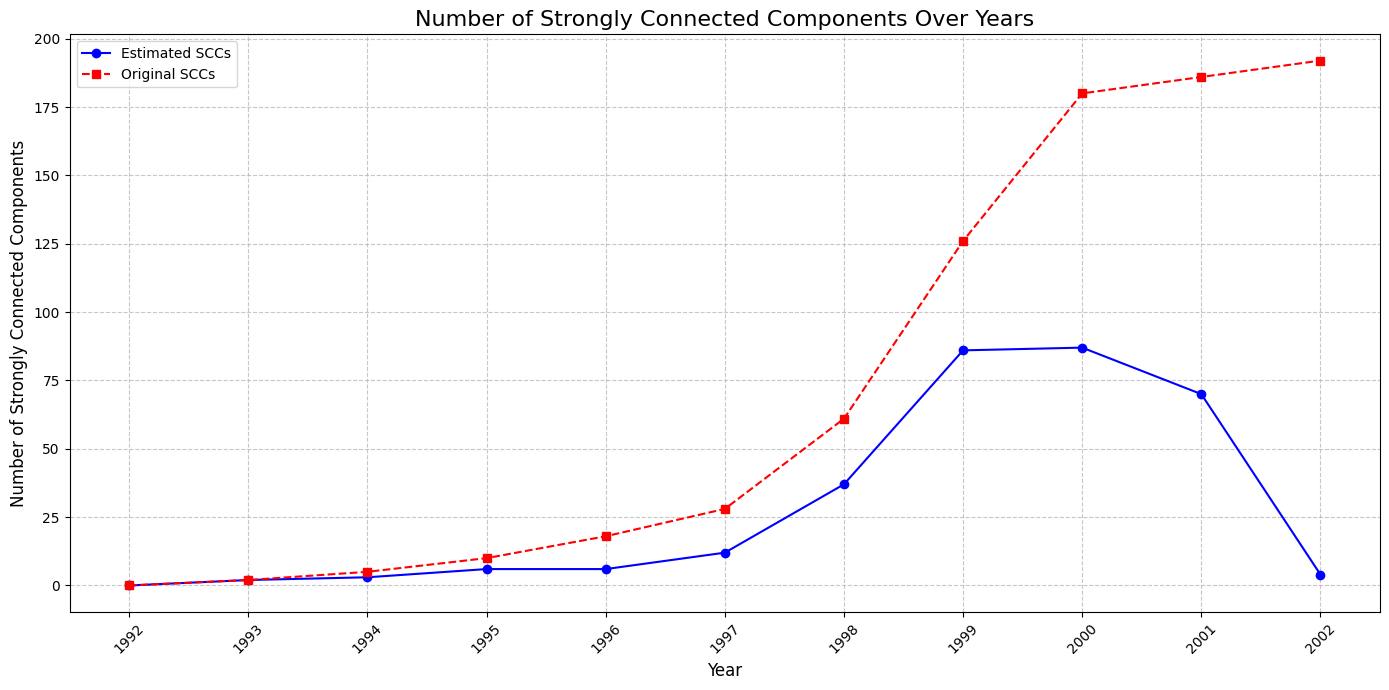

In [15]:

years = sorted(set(date.year for date in node_dates.values()))


graphs_estimated = []
for year in years:
    nodes_in_year = [node for node, date in node_dates.items() if date.year == year]
    subgraph = G.subgraph(nodes_in_year).copy()
    graphs_estimated.append(subgraph)


graphs_backup_per_year = []
for year in years:
    nodes_in_year_backup = [node for node, date in node_dates_backup.items() if date.year <= year]
    subgraph_backup = G_backup.subgraph(nodes_in_year_backup).copy()
    graphs_backup_per_year.append(subgraph_backup)


scc_counts_estimated = []
scc_counts_backup = []


for graph in tqdm(graphs_estimated, desc='Counting SCCs in Estimated Dataset'):
    sccs = nx.strongly_connected_components(graph)
    count = sum(1 for c in sccs if len(c) > 1)
    scc_counts_estimated.append(count)


for graph in tqdm(graphs_backup_per_year, desc='Counting SCCs in Original Dataset'):
    sccs = nx.strongly_connected_components(graph)
    count = sum(1 for c in sccs if len(c) > 1)
    scc_counts_backup.append(count)


plt.figure(figsize=(14, 7))
plt.plot(years, scc_counts_estimated, marker='o', linestyle='-', color='blue', label='Estimated SCCs')
plt.plot(years, scc_counts_backup, marker='s', linestyle='--', color='red', label='Original SCCs')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Strongly Connected Components', fontsize=12)
plt.title('Number of Strongly Connected Components Over Years', fontsize=16)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(years, rotation=45)
plt.tight_layout()
plt.show()


Analysis:
To understand dynamics of directed interaction (relevant for citation network) I chose strongly connected components over weakly connected components as a metric to observe of the graph over time. The increase in number of strongly connected components till 2000 shows the presence of distinct research communities and interdisciplinary collaborations culminating. The decrease in original dataset shows that the previous fields have consolidated their findings and strongly connected componenets (specialised subfields) perhaps merge in their research. However, the original dataset excludes certain nodes, that we have previously hypothesized to represent specific niche and isolated areas of research within HEP from 2000 onwards. This is illustrated by the incredible increase in number of SCCs in the estimated data plot. If this hypothesis is true, there should be a good increase in the size of SCCs from 2000 for the orginal dataset representing the merging of SCCs. Similarly, the SCCs should decrease in size for estimated data plot to show the emergence of new tiny subfields. Rather it should stagnate, as the large size of culminated fields from before 2000s averages out the smaller size of emerging niches.



Average size of SCCs over time

Calculating Avg SCC Size in Original Dataset: 100%|██████████| 11/11 [00:02<00:00,  4.39it/s]


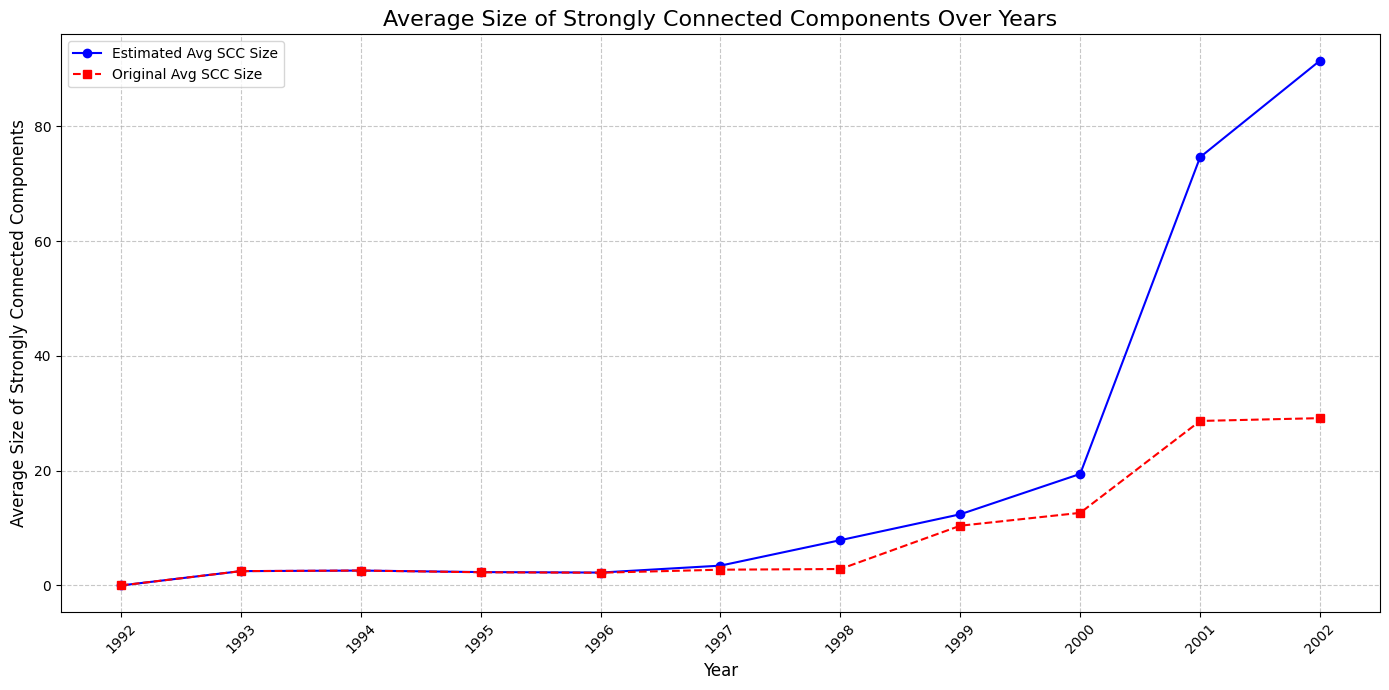

In [16]:

years = sorted(set(date.year for date in node_dates.values()))


graphs_estimated = []
for year in years:
    nodes_in_year = [node for node, date in node_dates.items() if date.year <= year]
    subgraph = G.subgraph(nodes_in_year).copy()
    graphs_estimated.append(subgraph)


graphs_backup_per_year = []
for year in years:
    nodes_in_year_backup = [node for node, date in node_dates_backup.items() if date.year <= year]
    subgraph_backup = G_backup.subgraph(nodes_in_year_backup).copy()
    graphs_backup_per_year.append(subgraph_backup)


avg_scc_sizes_estimated = []
avg_scc_sizes_backup = []


for graph in tqdm(graphs_estimated, desc='Calculating Avg SCC Size in Estimated Dataset'):
    sccs = nx.strongly_connected_components(graph)
    scc_sizes = [len(c) for c in sccs if len(c) > 1]
    avg_size = sum(scc_sizes) / len(scc_sizes) if scc_sizes else 0
    avg_scc_sizes_estimated.append(avg_size)


for graph in tqdm(graphs_backup_per_year, desc='Calculating Avg SCC Size in Original Dataset'):
    sccs = nx.strongly_connected_components(graph)
    scc_sizes = [len(c) for c in sccs if len(c) > 1]
    avg_size = sum(scc_sizes) / len(scc_sizes) if scc_sizes else 0
    avg_scc_sizes_backup.append(avg_size)


plt.figure(figsize=(14, 7))
plt.plot(years, avg_scc_sizes_estimated, marker='o', linestyle='-', color='blue', label='Estimated Avg SCC Size')
plt.plot(years, avg_scc_sizes_backup, marker='s', linestyle='--', color='red', label='Original Avg SCC Size')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Size of Strongly Connected Components', fontsize=12)
plt.title('Average Size of Strongly Connected Components Over Years', fontsize=16)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(years, rotation=45)
plt.tight_layout()
plt.show()

My predictions were accurate, validating my hypothesis about the trajectory of research in HEP-PH post 2000.

Task Outcome:
- Discovery of set of “special nodes”: could indicate a new specialisation cluster in 2001 to 2002 time period.
- Formulated a hypothesis for missing node date information.
- Determined the trajectory of area of study in HEP from 1992 to 2002:
  - Steady increase in specialised fields from 1992 which culminated into a cohesive research in 2000
  - Emergence of new, unrelated areas of study post 2000 that shifted the trajectory from the previous culmination of work.
